In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

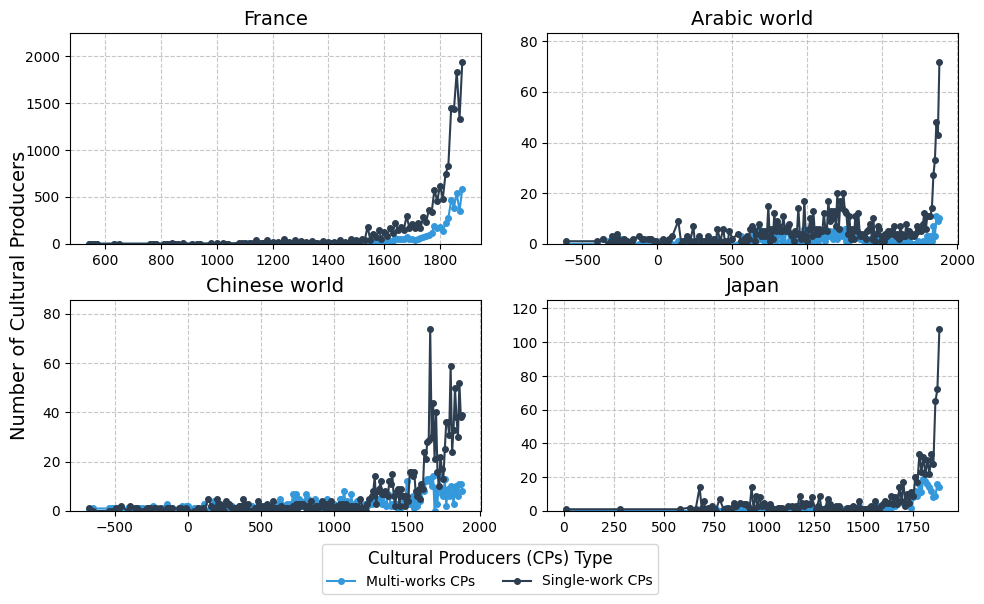

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../3-unseen_species_index/unseen_species_model/individuals_into_unseen_plus_>3.csv', index_col=[0])

# Select four interesting regions to compare
selected_regions = ['France', 'Arabic world', 'Chinese world', 'Japan']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# Store handles and labels for the legend
legend_handles = []
legend_labels = []

# Process each region
for i, region in enumerate(selected_regions):
    # Filter data for the current region
    sample_test = df[df['region_name'] == region]
    sample_test = sample_test[['individual_wikidata_id', 'decade', 'count_works']].drop_duplicates()
    sample_test = sample_test.reset_index(drop=True)
    
    # Handle zero counts
    sample_test['count_works'][sample_test['count_works'] == 0] = 1
    
    # Classify contributors
    contributor_work_counts = sample_test.groupby(['decade', 'individual_wikidata_id'])['count_works'].sum().reset_index()
    contributor_work_counts['contributor_type'] = contributor_work_counts['count_works'].apply(
        lambda x: 'Single-work CPs' if x == 1 else 'Multi-works CPs')
    
    # Aggregate by decade and contributor type
    decade_contributor_analysis = contributor_work_counts.groupby(['decade', 'contributor_type']).agg(
        unique_contributors=('individual_wikidata_id', 'nunique'),
        total_works=('count_works', 'sum')
    ).reset_index()
    
    # Pivot the data for plotting
    contributors_pivot = decade_contributor_analysis.pivot(
        index='decade', columns='contributor_type', values='unique_contributors').fillna(0)
    
    # Make sure both contributor types are present
    if 'Single-work CPs' not in contributors_pivot.columns:
        contributors_pivot['Single-work Cultural Producers'] = 0
    if 'Multi-works CPs' not in contributors_pivot.columns:
        contributors_pivot['Multi-works Cultural Producers'] = 0
    
    # Plot for the current region
    lines = contributors_pivot.plot(kind='line', marker='o', ax=axes[i], 
                           color=['#3498db', '#2c3e50'], linewidth=1.5, markersize=4,
                           legend=False)  # No legend for individual plots
    
    # Get handles and labels from the first plot only
    if i == 0:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    
    axes[i].set_title(f'{region}', fontsize=14)
    
    # Remove all y-labels from individual plots
    axes[i].set_ylabel('')
    
    # Set x-label only for bottom plots
    if i >= 2:  # For plots on the bottom (indices 2 and 3)
        axes[i].set_xlabel('', fontsize=12)
    else:
        axes[i].set_xlabel('')
    
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis to start from 0
    y_min, y_max = axes[i].get_ylim()
    axes[i].set_ylim(0, y_max * 1.1)  # Add 10% padding at the top

# First, apply tight layout to get good spacing
plt.tight_layout()

# Add a single legend to the figure
fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), 
           ncol=2, title='Cultural Producers (CPs) Type', fontsize=10, title_fontsize=12)

# Position the y-axis label closer to the figures
# Adjust the x-coordinate (first parameter) to move it closer to the plots
fig.text(0.02, 0.5, 'Number of Cultural Producers', va='center', rotation='vertical', fontsize=14)

# Adjust layout with space for the legend at the bottom
# Use a smaller left margin to keep the label closer to the plots
plt.subplots_adjust(bottom=0.14, left=0.08)

plt.show()